# VAE-Based Generative Modeling

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import sys
import os
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'
print(os.getcwd())
sys.path.append('../../..')
from contrib.DMI.ASIP_OSISAF.data_simple import *
from src.utils import *
from src.models import *
import matplotlib.pyplot as plt
import torch
import itertools
import geopandas as gpd
from geopandas import GeoSeries
import cartopy.feature as cfeature

datamodule = BaseDataModule(asip_paths="/dmidata/users/maxb/ASIP_OSISAF_dataset/PREPROC/asip_database_daw15.nc",
                            split_train=slice(0,900),
                            split_val=slice(900,950),
                            split_test=slice(950,1000))
                            
datamodule.setup()

data_loader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

/dmidata/users/maxb/4dvarnet-starter/Notebooks/Notebook_DMI/ASIP_OSISAF


# 1. Self attention mechanisms

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1) 
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf) 
        
        # Divide by d_k (Dim / H). 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head) 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1) 
        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v
        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 
        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape) 
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output) 
        # (Batch_Size, Seq_Len, Dim)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)
        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

# 2. VAE architectures

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    
    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue = x 

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)
        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w)) 
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)
        # Perform self-attention WITHOUT mask
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention(x)
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width) 
        x += residue

        # (Batch_Size, Features, Height, Width)
        return x 

class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)

        residue = x

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = F.silu(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_1(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.groupnorm_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = F.silu(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x + self.residual_layer(residue)

    
class VAE_Encoder(nn.Sequential):
    def __init__(self, in_channels=9, out_channels=28):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),  
             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), 
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(), 

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8). 
            nn.Conv2d(512, out_channels, kernel_size=3, padding=1), 

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0), 
        )

    def forward(self, x):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))
            
            x = module(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8. 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt()
        
        # reparametrization trick: Transform N(0, 1) -> N(mean, stdev) 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        noise = torch.Tensor(np.random.normal(size=mean.size(), scale=1.0)).to(x.device)
        x = mean + stdev * noise
        
        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        
        return x, mean, log_variance

class VAE_Decoder(nn.Sequential):
    def __init__(self,in_channels=14, out_channels=9):
        super().__init__(
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
            nn.Conv2d(in_channels, 4, kernel_size=1, padding=0),
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),   
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # Repeats the rows and columns of the data by scale_factor (like when you resize an image by doubling its size).
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Upsample(scale_factor=2),
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Upsample(scale_factor=2), 
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(512, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height, Width)
            nn.Upsample(scale_factor=2), 
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 256, Height, Width)
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(256, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.GroupNorm(32, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.SiLU(), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 3, Height, Width)
            nn.Conv2d(128, out_channels, kernel_size=3, padding=1), 
        )

    def forward(self, x):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        
        # Remove the scaling added by the Encoder.
        x /= 0.18215

        for module in self:
            x = module(x)

        # (Batch_Size, 3, Height, Width)
        return x

# VAE Model

In [5]:
device = "cuda"
class VAE(nn.Sequential):
    def __init__(self,in_channels=9, out_channels=28, sigma=5.0):
        super().__init__()
        self.encoder = VAE_Encoder(in_channels, out_channels).to(device)
        self.decoder = VAE_Decoder(out_channels//2,in_channels).to(device)
        
    def vae_loss(self, x, x_hat, mean, log_var, wKL=.01):
        err = x-x_hat
        err_num = err.isfinite()
        err_grad = sobel(x_hat)-sobel(x)
        err_grad_num = err_grad.isfinite()
        zeros= torch.zeros(err.size()).to(device)   
        if err_num.sum() == 0:
            return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
        reproduction_loss = F.mse_loss(err[err_num], torch.zeros_like(err[err_num]))
        grad_reproduction_loss = F.mse_loss(err_grad[err_grad_num], torch.zeros_like(err_grad[err_grad_num]))
        KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        return reproduction_loss + 10*grad_reproduction_loss + wKL*KLD, reproduction_loss, KLD
    
    def forward(self, x, diffusion=False):
        # encoder
        z, mean, log_var = self.encoder(x)
       # decoder
        x_hat = self.decoder(z)
        return x_hat
        
vae = VAE(in_channels=15, out_channels=50)

# Training

In [6]:
ckpt = torch.load('ckpt/ckpt_vae_srnn_ASIP_daw15.pth', map_location=device)
vae.load_state_dict(ckpt)

/tmp/ipykernel_108936/1022562096.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('ckpt/ckpt_vae_srnn_ASIP_daw15.pth', map_location=device)


<All keys matched successfully>

In [15]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler
from kornia.filters import sobel

n_epochs =  1000#@param {'type':'integer'}
## learning rate
lr = 3e-4 #@param {'type':'number'}

optimizer = Adam(
        [
            {"params": vae.encoder.parameters(), "lr": lr},
            {"params": vae.decoder.parameters(), "lr": lr},
        ],
    )
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 300, 400,450, 600,800,1000,1200,1400], gamma=0.5)
accumulation_steps = 16
optimizer.zero_grad()

tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for i, batch in enumerate(data_loader):
    #batch = batch.nan_to_num().to(device)
    x = batch[:,0,:,:,:].to(device) # ASIP data
    y = batch[:,1,:,:,:].to(device) # OSISAF data
    z, mean, log_var = vae.encoder(y.nan_to_num())
    x_hat = vae.decoder(z)
    loss_vae, rec, KL = vae.vae_loss(x, x_hat, mean, log_var, wKL=0.00001)
    loss = loss_vae 
    if torch.isnan(loss):
        continue
    #print(loss)
    loss = loss / accumulation_steps  # Normalize loss
    loss.backward()
    
    if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(vae.state_dict(), 'ckpt/ckpt_vae_srnn_ASIP_daw15.pth')
  scheduler.step()

  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt



In [8]:
import cmcrameri as cmc

def truncate_colormap(cmap, minval=0.0, maxval=1.0,n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                             'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name,
                              a=minval, b=maxval),
                              cmap(np.linspace(minval, maxval, n)))
    return new_cmap

sic_trunc = truncate_colormap(cmc.cm.oslo, minval=0.2, maxval=1, n=100)

/tmp/ipykernel_108936/2495835603.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(g.axes.flat):


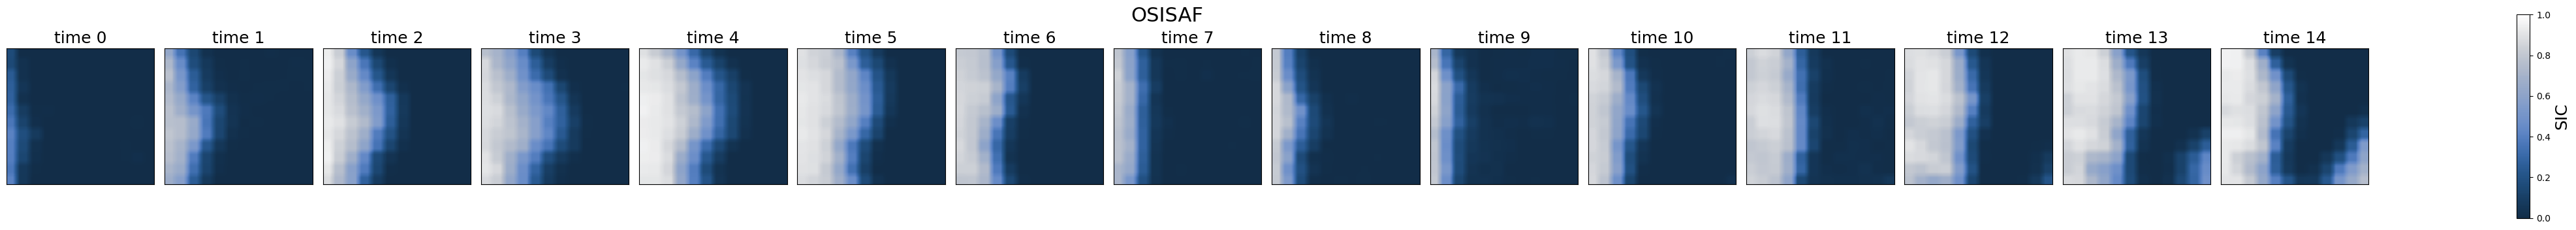

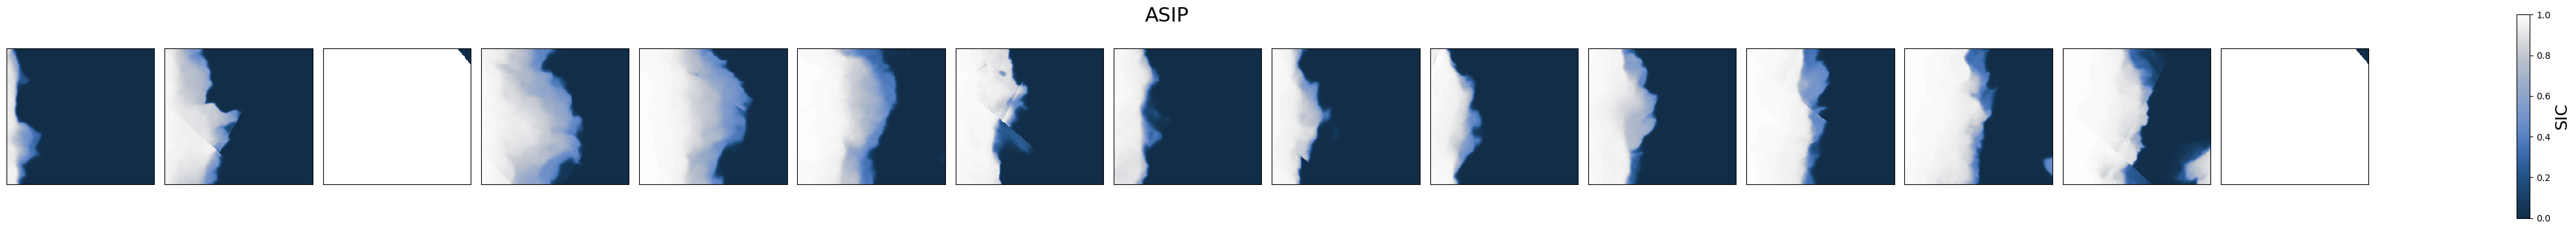

torch.Size([500, 1, 15, 240, 240])


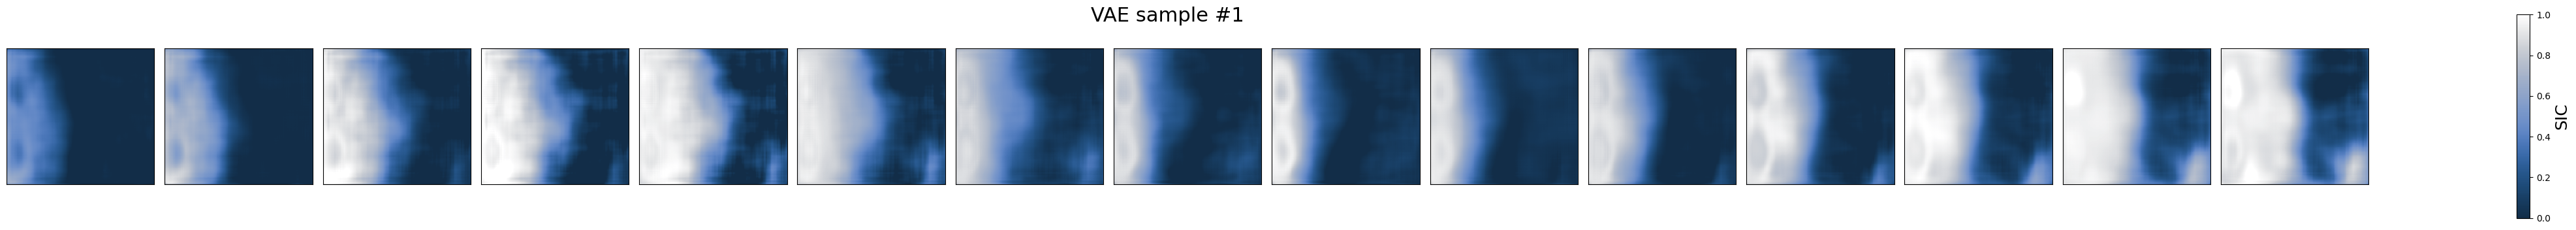

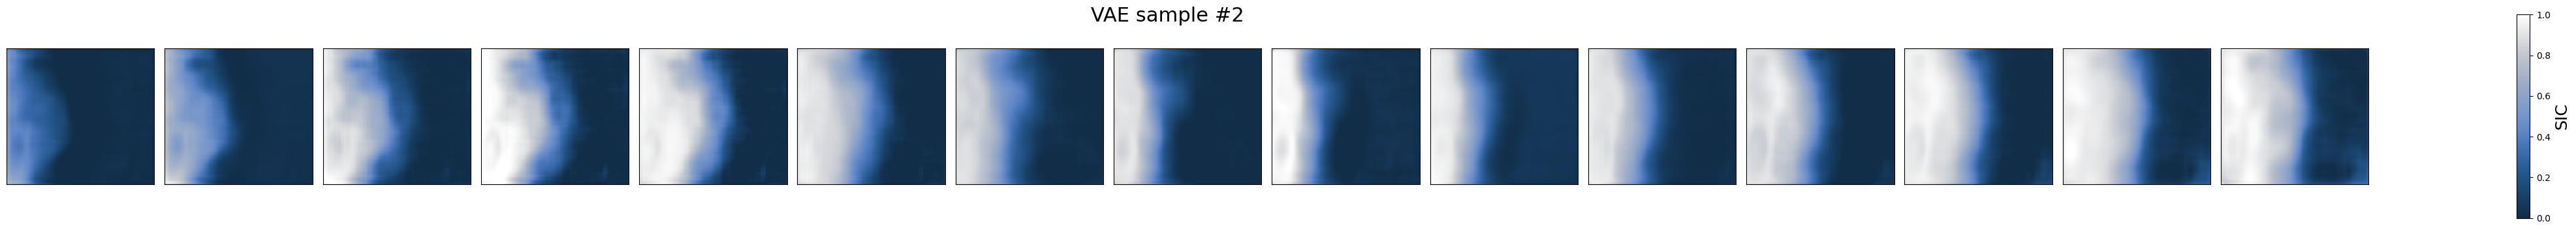

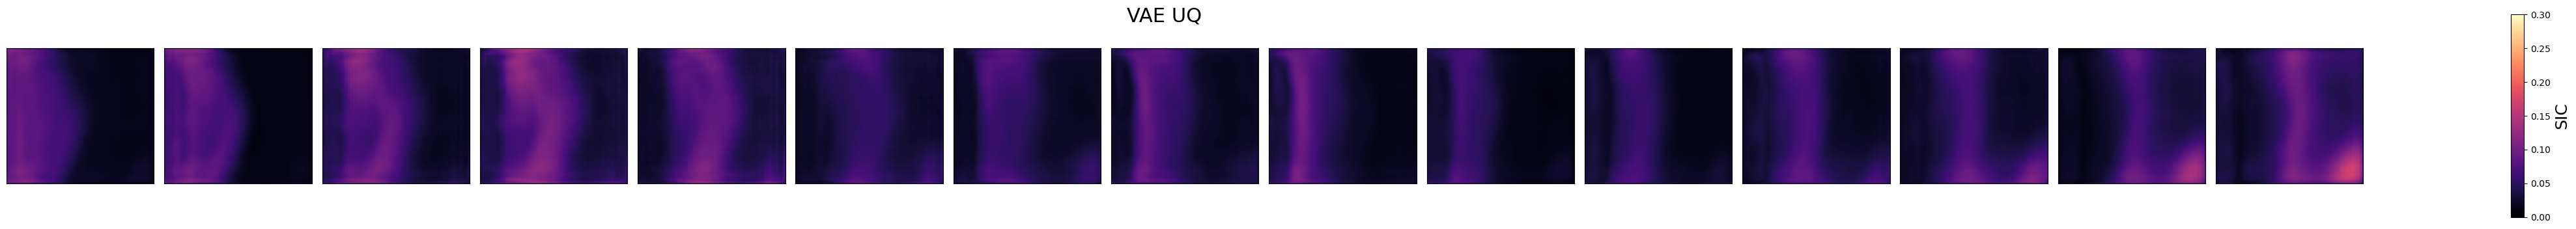

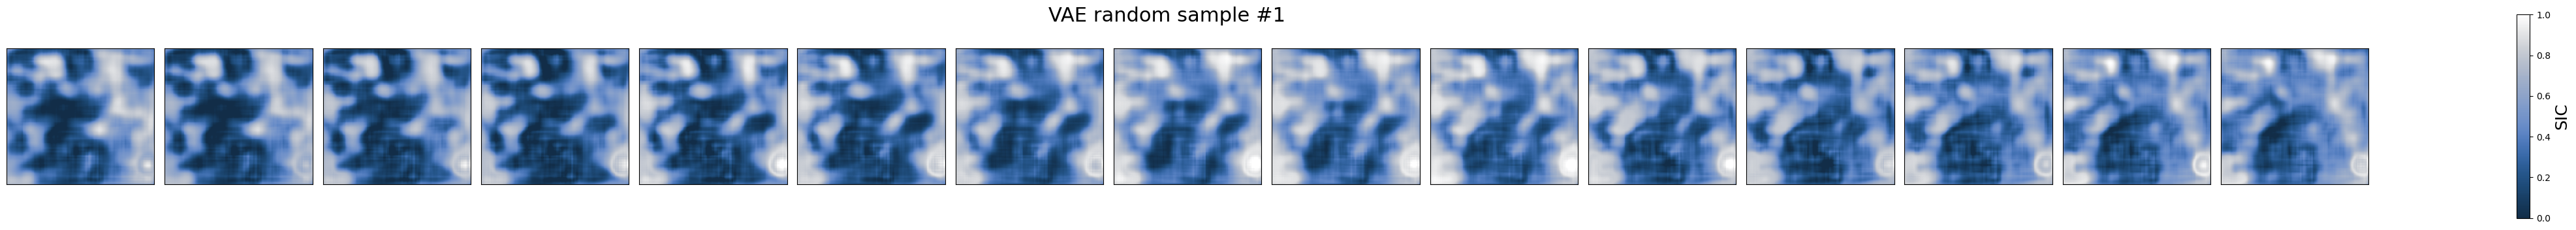

In [14]:
def custom_plot(g,time=False,title="OSISAF"):
    plt.suptitle(title,fontsize=22, y=1.1,x=0.4)
    g.cbar.set_label(label="SIC",fontsize=18)
    for i, ax in enumerate(g.axes.flat):
        if time:
            ax.set_title('time %d' % i,size=18)
        else:
            ax.set_title("")
        ax.set_xticks([])
        ax.set_yticks([]) 
        ax.set_xlabel("") 
        ax.set_ylabel("") 
        
x = x[[0]]
y = y[[0]]

g = xr.Dataset(data_vars={'SIC':(('time','lat','lon'),y.detach().cpu()[0])},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,extend="neither",
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
custom_plot(g,time=True)
plt.show()
g = xr.Dataset(data_vars={'SIC':(('time','lat','lon'),x.detach().cpu()[0])},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,extend="neither",
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
custom_plot(g,title="ASIP")
plt.show()

N_samples = 500
x_estim = []
for i in range(N_samples):
    x_estim.append(vae(y.nan_to_num().to(device),diffusion=False).detach().cpu())
x_estim = torch.stack(x_estim)
print(x_estim.shape)

g = xr.Dataset(data_vars={'SIC':(('time','lat','lon'),x_estim[10][0])},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,extend="neither",
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
custom_plot(g,title="VAE sample #1")
plt.show()
g = xr.Dataset(data_vars={'SIC':(('time','lat','lon'),x_estim[20][0])},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,extend="neither",
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
custom_plot(g,title="VAE sample #2")
plt.show()

g = xr.Dataset(data_vars={'SIC':(('time','lat','lon'),torch.std(x_estim,dim=0)[0])},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',cmap=plt.cm.magma,col_wrap=15,vmin=0,vmax=0.3,extend="neither",
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
custom_plot(g,title="VAE UQ")
plt.show()

z = torch.Tensor(np.random.normal(size=z.size(), scale=1.0)).to(device)
x_estim= vae.decoder(z)
g = xr.Dataset(data_vars={'SIC':(('time','lat','lon'),x_estim.detach().cpu()[0])},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).SIC.plot(col='time',col_wrap=15,vmin=0,vmax=1,cmap=sic_trunc,extend="neither",
                                                            cbar_kwargs={'shrink': 1.5, 'aspect': 15})
custom_plot(g,title="VAE random sample #1")
plt.show()